## Clickbait spoiling notebook

In [2]:
# Data processing
import pandas as pd
import re
import json
import numpy as np
import math

# OpenAI connection
import os
from dotenv import load_dotenv
from openai import OpenAI
import tiktoken
from typing import List
from datetime import datetime

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, BertModel
from bert_score import BERTScorer

In [3]:
# VARIABLES
load_dotenv()
api_key = os.getenv("OPEN_AI_KEY")
nltk.download('wordnet')
nltk.download('punkt_tab')

N = 400 # Number of samples for charts
RANDOM_STATE = 42 # Random state for reproducibility

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wojom\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\wojom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
def calculate_cost(prompt: str, data: str, out: str, model: str = "gpt-4o-mini") -> float:
    """
    Calculates the cost of a request to a OPEN AI model based on the 
    , data, and output

    Args:
        prompt (str): prompt sent to the LLM
        data (str): additional data sent to the LLM.
        out (str): response received from the LLM.
        model (str): model identifier used to determine the tokenizer, defaults to "gpt-4o-mini"

    Returns:
        float: total cost of the tokens used in USD
    """
    tokenizer = tiktoken.encoding_for_model(model)  
    request = str(prompt) + str(data)
    response = str(out)

    request_tokens = tokenizer.encode(request)
    response_tokens = tokenizer.encode(response)

    input_tokens = len(request_tokens)
    output_tokens = len(response_tokens)

    # costs per 1 million tokens
    cost_per_1M_input_tokens = 0.15  # $0.15 per 1M input tokens
    cost_per_1M_output_tokens = 0.60  # $0.60 per 1M output tokens

    input_cost = (input_tokens / 10**6) * cost_per_1M_input_tokens
    output_cost = (output_tokens / 10**6) * cost_per_1M_output_tokens
    total_cost = input_cost + output_cost
    total_tokens = input_tokens + output_tokens

    print(f"Input tokens: {input_tokens}")
    print(f"Output tokens: {output_tokens}")
    print(f"Total tokens: {total_tokens}")
    print(f"Cost: ${total_cost:.5f}")
    return total_cost, total_tokens

In [5]:
spoil_df = pd.read_csv("../data/spoiling_data.csv", sep=";")
print(spoil_df.shape)
tags = spoil_df["tags"].unique().tolist()
print(tags)

(3358, 6)
['passage', 'phrase', 'multi']


In [6]:
spoil_df = spoil_df.dropna()
spoil_df.isna().sum()

targetTitle         0
targetParagraphs    0
humanSpoiler        0
spoiler             0
tags                0
spoilerPositions    0
dtype: int64

In [7]:
client = OpenAI(api_key=api_key)

In [8]:
spoil_df["paragraphsLength"] = spoil_df["targetParagraphs"].apply(lambda x: len(x))
mean_length = spoil_df["paragraphsLength"].mean()
median_length = spoil_df["paragraphsLength"].median()

print("Mean length of the paragraph:", mean_length)
print("Median length of the paragraph:", median_length)

Mean length of the paragraph: 2864.8784629133156
Median length of the paragraph: 1974.0


### Direct Prompt

In [9]:
spoil_df[spoil_df["paragraphsLength"] == min(spoil_df["paragraphsLength"])]

,targetTitle,targetParagraphs,humanSpoiler,spoiler,tags,spoilerPositions,paragraphsLength
696,The Grand Tour launch date,November 18 The Grand Tour: Launch Date,November 18,November 18,phrase,"[[[0, 0], [0, 11]]]",39


In [10]:
pd.set_option('display.max_colwidth', None)
examples = {}
tags = spoil_df["tags"].unique()

for tag in tags:
    spoiler = spoil_df.loc[(spoil_df["tags"] == tag) & (spoil_df["paragraphsLength"] < 1000)].iloc[0]
    examples[tag] = {
        "tag": spoiler["tags"],
        "spoiler": spoiler["spoiler"],
        "title": spoiler["targetTitle"],
        "paragraph": spoiler["targetParagraphs"],
        "human_spoiler": spoiler["humanSpoiler"],
        "length": spoiler["paragraphsLength"]
    }


print(examples["multi"]["spoiler"])
pd.set_option('display.max_colwidth', 50)

pravastatin, paroxetine


In [130]:
system_prompt = f"""\
You are a model designed to generate concise spoilers from articles as "humanSpoiler" and extract article body paragraphs that provide information for the spoiler as "spoiler". The "spoiler" paragraphs should form a consistent text.\
Your task is to analyze the main question or topic posed by the article’s title ("targetTitle") and generate a spoiler based on the content provided in the article’s paragraphs ("targetParagraphs"). Your response must include a JSON object with the keys "humanSpoiler" and "spoiler".\
Guidelines:\
1. Use "targetTitle" to determine the central question or topic the spoiler should address.\
2. Review "targetParagraphs" to find the most relevant details that directly answer the question or topic posed in the title.\
3. Consider the provided tag to adjust your response:\
"phrase": Provide a short, direct answer or single phrase.\
"passage": Provide a more detailed, informative spoiler.\
"multi": Provide multiple sentences or a structured, longer spoiler.\
\
Example Answer: {{\
    "humanSpoiler": "<A model-generated spoiler>",\
    "spoiler": "<A concise, extracted from the article’s content but remaining logical>"\
}}\
Example 1:\
Input{{\
    "idx": 1,\
    "tag": "phrase",\
    "targetTitle": {examples['phrase']['title']},\
    "targetParagraphs": {examples["phrase"]["paragraph"]}\
}}\
\
Output{{\
    "idx":1,\
    "humanSpoiler": {examples["phrase"]["human_spoiler"]},\
    "spoiler": {examples["phrase"]["spoiler"]}\
}}\
\
Example 2:\
Input{{\
    "idx":2,\
    "tag": "passage",\
    "targetTitle": {examples["passage"]["title"]},\
    "targetParagraphs": {examples["passage"]["paragraph"]}\
}}\
Output{{\
    "idx":2,\
    "humanSpoiler": {examples["passage"]["human_spoiler"]},\
    "spoiler": {examples["passage"]["spoiler"]}\
}}\
\
Example 3:\
Input{{\
    "idx:3"\
    "tag": "multi",\
    "targetTitle": {examples["multi"]["title"]},\
    "targetParagraphs": {examples["multi"]["paragraph"]}\
}}\
Output{{\
    "idx:3"\
    "humanSpoiler": {examples["multi"]["human_spoiler"]},\
    "spoiler": {examples["multi"]["spoiler"]}\
}}\
Pay attention to return valid JSON format!\
"""

In [131]:
system_prompt

'You are a model designed to generate concise spoilers from articles as "humanSpoiler" and extract article body paragraphs that provide information for the spoiler as "spoiler". The "spoiler" paragraphs should form a consistent text.Your task is to analyze the main question or topic posed by the article’s title ("targetTitle") and generate a spoiler based on the content provided in the article’s paragraphs ("targetParagraphs"). Your response must include a JSON object with the keys "humanSpoiler" and "spoiler".Guidelines:1. Use "targetTitle" to determine the central question or topic the spoiler should address.2. Review "targetParagraphs" to find the most relevant details that directly answer the question or topic posed in the title.3. Consider the provided tag to adjust your response:"phrase": Provide a short, direct answer or single phrase."passage": Provide a more detailed, informative spoiler."multi": Provide multiple sentences or a structured, longer spoiler.Example Answer: {    "

In [132]:
cost_one, tokens_one = calculate_cost(prompt=system_prompt, data=system_prompt, out="Intellectual stimulation")
print(f"Total cost: ${cost_one * 3500}")

Input tokens: 1780
Output tokens: 3
Total tokens: 1783
Cost: $0.00027
Total cost: $0.9407999999999999


In [133]:
def sample_test_df(df, types_of_spoilers, num_samples, random_state=RANDOM_STATE):
    samples = []
    for tag in types_of_spoilers:
        sample = df[df['tags'] == tag].sample(num_samples, random_state=random_state)
        samples.append(sample)
    test_df = pd.concat(samples).reset_index(drop=True)
    return test_df

In [134]:
test_df = sample_test_df(spoil_df, types_of_spoilers=['passage', 'phrase', 'multi'], num_samples=10)
test_df.shape

(30, 7)

### Call to the OpenAI. Response saved as file

In [135]:
def create_batch_request_to_open_ai_direct_prompt(
    list_of_prompts: List[str],
    system_prompt: str,
    name_of_request_file: str,
    description_of_request: str,   
    temperature: None = 1, #between [0,2]. Default = 1, higher temperature leads to more random, while lower to more deterministic,
    model: str = "gpt-4o-mini"
):

    dictionary = [{
        "custom_id": f"request{i}", 
        "method": "POST", 
        "url": "/v1/chat/completions", 
        "body": {"model": model, 
                 "messages": [
                     {"role": "system", "content": f"{system_prompt}"},
                     {"role": "user", "content": prompt}],
                 "max_tokens": 1000,
                 "temperature": temperature}
    } for i, prompt in enumerate(list_of_prompts)]
    
    with open(f"../request_files_openai/{name_of_request_file}.jsonl", "w") as outfile:
        for request in dictionary:
            json.dump(request, outfile)
            outfile.write('\n')
    
    
    batch_input_file = client.files.create(
      file=open(fr"../request_files_openai/{name_of_request_file}.jsonl", "rb"),
      purpose="batch"
    )
    
    return client.batches.create(
        input_file_id=batch_input_file.id,
        endpoint="/v1/chat/completions",
        completion_window="24h",
        metadata={
          "description": description_of_request
        }
    )

In [136]:
def save_direct_prompt_to_file_and_get_predictions(
    result_file_id: str,
    result_file_name: str,
    save_to_file: bool = True
):
    if save_to_file:
        result = client.files.content(result_file_id).content
        result_file_name = f"../request_files_openai/{result_file_name}.jsonl"
        
        with open(result_file_name, 'wb') as file:
            file.write(result)

    pred = []
    with open(result_file_name, 'r') as file:
        i = 0
        for line in file:
            prediction_str = json.loads(line)['response']['body']['choices'][0]['message']['content']
            try:
                pred.append(str(prediction_str))
            except Exception as e:
                print("there was problem with this request. Output:")
                print(prediction_str)
                print()
                pred.append(0)
                i+=1
    print(f"number of errors = {i}")
    return pred

In [137]:
def create_prompt(df):
    prompt_res = [
        str(f'Article to spoil: "idx":{idx}, "tag":{entry["tags"]}, "targetTitle":{entry["targetTitle"]}, "targetParagraphs":{entry["targetParagraphs"]}')
        for idx, entry in df.iterrows()
    ]
    return prompt_res

In [160]:
def divide_for_batches(data_prompt, num_batches):
    batches = []
    size = len(data_prompt) // num_batches
    for i in range(num_batches):
        if i == num_batches-1:
            batches.append(data_prompt[size*i:])
            break
        batches.append(data_prompt[size*i:size*(i+1)])
    return batches

Call to OpenAI with the whole dataset

In [139]:
# data_prompt = create_prompt(test_df)
data_prompt = create_prompt(spoil_df)
print("Length of the prompt:", len(data_prompt))

Length of the prompt: 3357


In [173]:
toatal_cost, total_tokens = calculate_cost(prompt=data_prompt, data=system_prompt*int((len(data_prompt)*1.05)), out=data_prompt[0])
tokens_limit = 2000000
num_batches = math.ceil(total_tokens/tokens_limit)
num_batches += 1
print("Number of batches to form from data:", num_batches)

Input tokens: 5328745
Output tokens: 416
Total tokens: 5329161
Cost: $0.79956
Number of batches to form from data: 4


In [174]:
prompt_batches = divide_for_batches(data_prompt, num_batches)
print("Num of batches:", len(prompt_batches))

Num of batches: 4


In [175]:
data_batch = create_batch_request_to_open_ai_direct_prompt(
        list_of_prompts = prompt_batches[0],
        system_prompt=system_prompt,
        name_of_request_file = "request_spoiling",
        description_of_request = f"request_spoiling_{str(datetime.now().date())}_batch_{0})",
)

In [176]:
batches = client.batches.list()
batches.data

[Batch(id='batch_6754a3815f6c819183418d3e87b5700c', completion_window='24h', created_at=1733600129, endpoint='/v1/chat/completions', input_file_id='file-JHRYHBiQzZuFJsHJH8jBpp', object='batch', status='in_progress', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1733686529, failed_at=None, finalizing_at=None, in_progress_at=1733600131, metadata={'description': 'request_spoiling_2024-12-07_batch_0)'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=839)),
 Batch(id='batch_6754a259964881919f3217f5bd33a4eb', completion_window='24h', created_at=1733599833, endpoint='/v1/chat/completions', input_file_id='file-2H9Thkr755MtmxTW7Bz5sV', object='batch', status='failed', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=Errors(data=[BatchError(code='token_limit_exceeded', line=None, message='Enqueued token limit reached for gpt-4o-mini in organization org

In [177]:
print(data_batch.id)

batch_6754a3815f6c819183418d3e87b5700c


In [178]:
in_progress_data_batch = client.batches.retrieve(data_batch.id)
print("Batch in progress output file id:", in_progress_data_batch.output_file_id)
print("Batch details:", in_progress_data_batch)

Batch in progress output file id: None
Batch details: Batch(id='batch_6754a3815f6c819183418d3e87b5700c', completion_window='24h', created_at=1733600129, endpoint='/v1/chat/completions', input_file_id='file-JHRYHBiQzZuFJsHJH8jBpp', object='batch', status='in_progress', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1733686529, failed_at=None, finalizing_at=None, in_progress_at=1733600131, metadata={'description': 'request_spoiling_2024-12-07_batch_0)'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=839))


In [92]:
file_response = client.files.content(in_progress_data_batch.output_file_id).content

In [93]:
pred = save_direct_prompt_to_file_and_get_predictions(
    result_file_id = in_progress_data_batch.output_file_id,
    result_file_name = f"response_spoiling_test_{str(datetime.now().date())}_batch_{0}"
)

number of errors = 0


### Spoiling analysis from files

In [40]:
file_names = [
    "response_spoiling_2024-11-20_batch_0", 
    "response_spoiling_2024-11-21_batch_1", 
    "response_spoiling_2024-11-21_batch_2"
    ]

In [41]:
pred = []
for file_name in file_names:
    result_file_name = "../request_files_openai/" + file_name + ".jsonl"
    pred_file = save_direct_prompt_to_file_and_get_predictions(
        result_file_id = None,
        result_file_name = result_file_name,
        save_to_file = False
    )
    pred.extend(pred_file)
print(len(pred))

number of errors = 0
number of errors = 0
number of errors = 0
3358


In [42]:
def extract_data_regex(pred):
    pattern = r'[{}\n":,]'
    human_spoiler_pattern = r'"humanSpoiler"\s*:\s*"([^"]+)"'
    spoiler_pattern = r'"spoiler"\s*:\s*"([^"]+)"'
    data = []

    for text in pred:
        human_spoiler_value = spoiler_value = None
        human_spoiler_match = re.search(human_spoiler_pattern, text)
        spoiler_match = re.search(spoiler_pattern, text)
        if human_spoiler_match:
            human_spoiler_value = human_spoiler_match.group(1)
        else:
            match = re.search(r'humanSpoiler', text)
            if match:
                start_index = match.start()
                human_spoiler_value = text[start_index+12:] 
        
        if spoiler_match:
            spoiler_value = spoiler_match.group(1)
        else:
            match = re.search(r'spoiler', text)
            if match:
                start_index = match.start()
                spoiler_value = text[start_index+7:] 
        
        
        data.append({
            "humanSpoiler": human_spoiler_value,
            "spoiler": spoiler_value
        })

    df = pd.DataFrame(data)
    return df


In [43]:
def load_json_result(result, tags):
    json_spoiler = json.loads(result)
    data_point = {
        "humanSpoiler": json_spoiler[tags[0]],
        "spoiler": json_spoiler[tags[1]]
    }
    return data_point
    
def extract_data(pred):
    wrong_rows = []
    data = []
    for i in range(len(pred)):
        match = re.search(r'\{.*?\}', pred[i], re.DOTALL)
        if match:
            result = match.group(0)
            try:
                data.append([load_json_result(result, tags = ["humanSpoiler", "spoiler"]), i])
            except json.JSONDecodeError as e:
                try:
                    result = result.replace('"humanSpoiler": ', '"humanSpoiler": "')
                    result = result.replace('"spoiler": ', '"spoiler": "')
                    result = result.replace('\n}', '"\n}')
                    data.append([load_json_result(result, tags = ["humanSpoiler", "spoiler"]), i])
                except json.JSONDecodeError as e:
                    wrong_rows.append(spoiler)
                    print(f"JSON decode error: {e}")      
        else:
            print("No match found.")
    idx = [el[1] for el in data]
    data = [el[0] for el in data]
    data = pd.DataFrame(data)
    data["idx"] = idx
    return data, wrong_rows

In [94]:
extracted_df, wrong_rows = extract_data(pred)
na_rows = extracted_df[extracted_df.isna().any(axis=1)]

print("\nExtracted data size: ", extracted_df.shape)
print("Non-extracted data size: ", len(wrong_rows))
print("Rows with NaN values in extracted data: ", na_rows.shape)


Extracted data size:  (30, 3)
Non-extracted data size:  0
Rows with NaN values in extracted data:  (0, 3)


In [101]:
extracted_df.head()

,humanSpoiler,spoiler,idx
0,Local authorities are requiring a halal superm...,"A halal supermarket in Colombes, Paris, has be...",0
1,Strange and outdated laws from different state...,"In Florida, a priest was fined for feeding a h...",1
2,Voting for Trump is viewed as a morally good c...,The article argues that despite Donald Trump's...,2
3,15 minutes of cuddling after sex boosts relati...,The most important part of enhancing your inti...,3
4,"The Model 3 is $35,000, potential $25,000 with...","Tesla's Model 3 has a base price of $35,000, b...",4


### Calculating Metrics
- **BLEU**
- **BERTScore (BSc)**
- **METEOR (MET)**
- **Cosine Similarity**

The dataset with spoilers from OpenAI and all calculated metrics is saved as: `../data/spoiling_metrics_df.csv`. Generating the dataset again is computationally expensive!


In [46]:
def plotHistograms(df, columns, xlabels, titles, kde=False, log=False, font_size=12):
    number = len(columns)
    fig, axs = plt.subplots(1, number, figsize=(12, 5))
    bins = np.linspace(0, 1, 11)

    for i in range(number):
        sns.histplot(df[columns[i]], bins=bins, kde=kde, ax=axs[i], edgecolor="black")
        axs[i].set_xlabel(xlabels[i], fontsize=font_size)
        axs[i].set_ylabel('Counts' + (' (log scale)' if log else ''), fontsize=font_size)
        axs[i].set_title(titles[i], fontsize=font_size + 2)
        axs[i].tick_params(axis='both', which='major', labelsize=font_size - 2)  # Adjust tick font size
        if log:
            axs[i].set_yscale('log')
    plt.tight_layout()
    plt.show()

In [47]:
def plot_scatterplot(df, columns, legend_labels, mean_labels, xlabel, ylabel, title, random_state=RANDOM_STATE, n=N, fontsize=14):
    sampled_0 = df[columns[0]].sample(n=n, random_state=random_state)
    sampled_1 = df[columns[1]].sample(n=n, random_state=random_state)

    human_spoiler_mean = df[columns[0]].mean()
    spoiler_mean = df[columns[1]].mean()

    plt.figure(figsize=(10, 6))

    plt.scatter(
        range(len(sampled_0)), 
        sampled_0, 
        alpha=0.7, 
        color='blue', 
        label=legend_labels[0]
    )

    plt.scatter(
        range(len(sampled_1)), 
        sampled_1, 
        alpha=0.7, 
        color='orange', 
        label=legend_labels[1]
    )

    plt.axhline(y=human_spoiler_mean, color='blue', linestyle='--', label=mean_labels[0])
    plt.axhline(y=spoiler_mean, color='orange', linestyle='--', label=mean_labels[1])

    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.title(title, fontsize=fontsize+2)
    plt.legend(loc='upper right', prop={'size': fontsize-2})

    plt.xticks(fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-2)

    plt.tight_layout()
    plt.show()


In [48]:
# metrics df laded from csv:
metrics_df = pd.read_csv("../data/spoiling_metrics_df.csv", sep=";")

FileNotFoundError: [Errno 2] No such file or directory: '../data/spoiling_metrics_df.csv'

In [ ]:
metrics_df.head()

(3309, 13)

In [ ]:
metrics_df = extracted_df.merge(test_df, left_on='idx', right_index=True)
metrics_df.rename(columns={
    'humanSpoiler_x': 'humanSpoiler_ext', 
    'spoiler_x': 'spoiler_ext',
    'humanSpoiler_y': 'humanSpoiler_org', 
    'spoiler_y': 'spoiler_org',
    }, inplace=True)
metrics_df.drop(columns=["idx"], inplace=True)
metrics_df.head()

,humanSpoiler_ext,spoiler_ext,targetTitle,targetParagraphs,humanSpoiler_org,spoiler_org,tags,spoilerPositions,paragraphsLength
0,Local authorities are requiring a halal superm...,"A halal supermarket in Colombes, Paris, has be...",Halal supermarket in Paris told to sell pork a...,A halal supermarket in Paris has been ordered ...,Its because the store did not go through the p...,It argues that members of the local community ...,passage,"[[[2, 0], [2, 127]]]",7960
1,Strange and outdated laws from different state...,"In Florida, a priest was fined for feeding a h...",Here Are 11 Ridiculously Strange Laws That Sti...,Usually if you follow your conscience and know...,Alabama has a law against it. #StopClickBait,If you find yourself so moved to store ice cre...,passage,"[[[19, 0], [19, 142]]]",2030
2,Voting for Trump is viewed as a morally good c...,The article argues that despite Donald Trump's...,Why Voting for Donald Trump Is a Morally Good ...,Some of my Christian friends tell me they cann...,Because Clinton and her liberal agenda will hu...,nothing morally wrong with voting for a flawed...,passage,"[[[4, 86], [4, 209]]]",32139
3,15 minutes of cuddling after sex boosts relati...,The most important part of enhancing your inti...,15 Minutes That Could Change Your Sex Life,"The romantic woo: the flowers, the dinner, the...",15 minutes of post-sex cuddling strengthens re...,15 minutes of post-coitus cuddling boosts rela...,passage,"[[[2, 0], [2, 68]]]",1774
4,"The Model 3 is $35,000, potential $25,000 with...","Tesla's Model 3 has a base price of $35,000, b...","A $25,000 Tesla Sounds Great, But Is It For Real?",Tesla will soon accept deposits for its long-a...,I will not be no.,"limited to the first 200,000 vehicles sold",passage,"[[[7, 54], [7, 96]]]",2203


#### Cosine Similarity for spoiler, humanSpoiler

In [ ]:
# poprawić trenowanie dla calego datasetu
def calculate_cosine_similarity_row(row, columns, vectorizer=TfidfVectorizer()):
    tfidf_matrix = vectorizer.transform([row[columns[0]], row[columns[1]]])
    cosine_sim = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]
    return cosine_sim

In [104]:
# Vectorizer for human spoilers
corpus_hs = metrics_df["humanSpoiler_org"].tolist()
vectorizer_hs = TfidfVectorizer()
vectorizer_hs.fit(corpus_hs)

# Vectorizer for human spoilers
corpus_s = metrics_df["spoiler_org"].tolist()
vectorizer_s = TfidfVectorizer()
vectorizer_s.fit(corpus_s)

TfidfVectorizer()

In [105]:
metrics_df['humanSpoiler_cos_sim'] = metrics_df.apply(calculate_cosine_similarity_row, axis=1, columns=['humanSpoiler_ext', 'humanSpoiler_org'], vectorizer=vectorizer_hs)
metrics_df['spoiler_cos_sim'] = metrics_df.apply(calculate_cosine_similarity_row, axis=1, columns=['spoiler_ext', 'spoiler_org'], vectorizer=vectorizer_s)

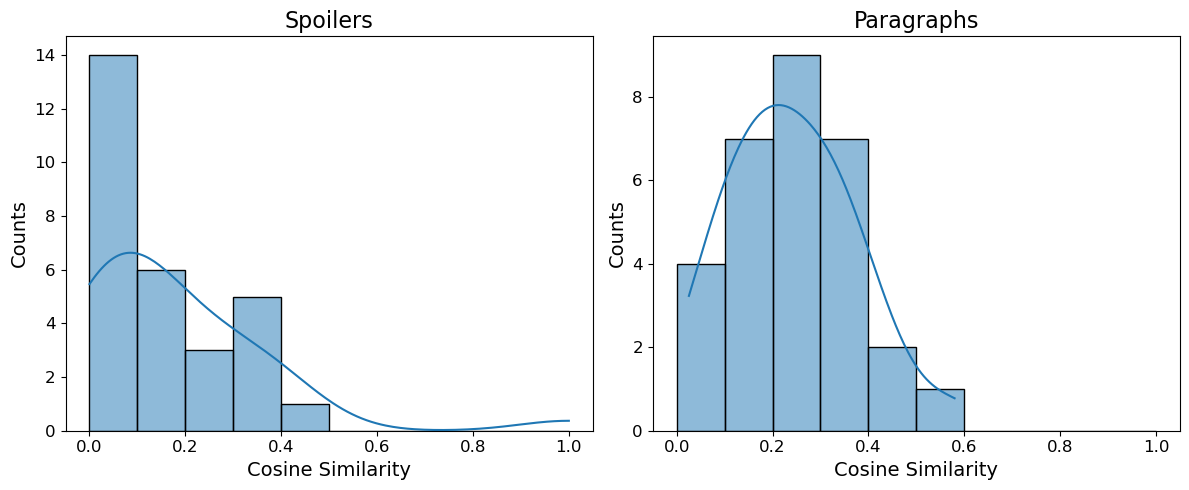

In [106]:
xlabels = ['Cosine Similarity', 'Cosine Similarity']
titles = ['Spoilers', 'Paragraphs']
plotHistograms(metrics_df, columns=["humanSpoiler_cos_sim", "spoiler_cos_sim"], xlabels=xlabels, titles=titles, kde=True, font_size=14)

In [107]:
print("Mean of humanSpoiler_cos_sim: ", metrics_df["humanSpoiler_cos_sim"].mean())
print("Mean of spoiler_cos_sim: ", metrics_df["spoiler_cos_sim"].mean())

Mean of humanSpoiler_cos_sim:  0.18036907325577156
Mean of spoiler_cos_sim:  0.24084816196323228


In [108]:
plot_scatterplot(
    df=metrics_df, 
    columns=["humanSpoiler_cos_sim", "spoiler_cos_sim"], 
    legend_labels=['Spoilers (Sampled)', 'Paragraphs (Sampled)'], 
    mean_labels=['Mean (Spoilers)', 'Mean (Paragraphs)'], 
    xlabel='Index (Random Sample)', 
    ylabel='Cosine Similarity', 
    title='Cosine Similarity Between Generated and Original Texts (Sampled)', 
    random_state=RANDOM_STATE, 
    n=N
    )

ValueError: Cannot take a larger sample than population when 'replace=False'

In general, the model 'gpt-4o-mini' identifies paragraphs for extracting spoilers with higher mean value than the similarity of generated spoilers.

#### METEOR (MET) for spoiler, humanSpoiler
https://www.nltk.org/api/nltk.translate.meteor_score.html

In [109]:
def calculate_met_nltk(row, columns):
    tokenized_candidate = word_tokenize(row[columns[0]])
    tokenized_reference = word_tokenize(row[columns[1]])

    return meteor_score([tokenized_reference], tokenized_candidate)

In [110]:
metrics_df["humanSpoiler_met"] = metrics_df.apply(calculate_met_nltk, axis=1, columns=['humanSpoiler_ext', 'humanSpoiler_org'])
metrics_df['spoiler_met'] = metrics_df.apply(calculate_met_nltk, axis=1, columns=['spoiler_ext', 'spoiler_org'])

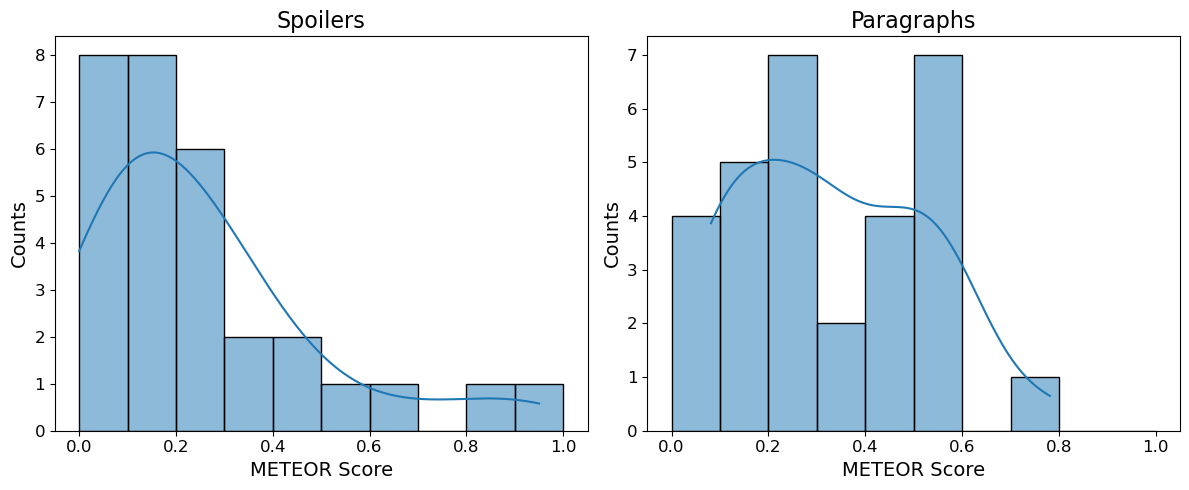

In [111]:
xlabels = ['METEOR Score','METEOR Score']
titles = ['Spoilers','Paragraphs']
plotHistograms(metrics_df, columns=["humanSpoiler_met", "spoiler_met"], xlabels=xlabels, titles=titles, kde=True, font_size=14)

In [112]:
print("Mean of humanSpoiler_met: ", metrics_df["humanSpoiler_met"].mean())
print("Mean of spoiler_met: ", metrics_df["spoiler_met"].mean())

Mean of humanSpoiler_met:  0.2557128383381739
Mean of spoiler_met:  0.3347461287839129


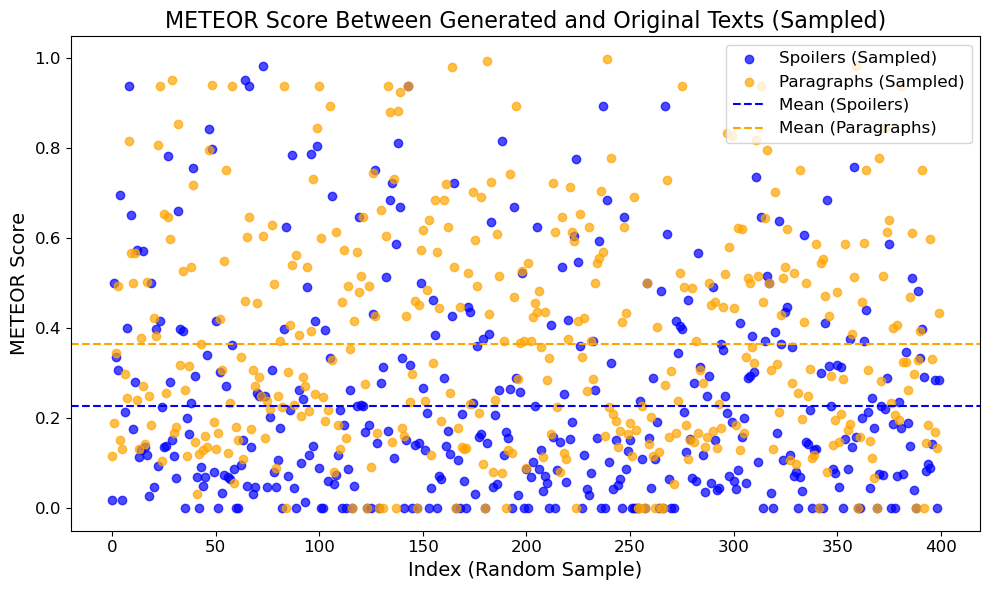

In [119]:
plot_scatterplot(
    df=metrics_df, 
    columns=["humanSpoiler_met", "spoiler_met"], 
    legend_labels=['Spoilers (Sampled)', 'Paragraphs (Sampled)'], 
    mean_labels=['Mean (Spoilers)', 'Mean (Paragraphs)'], 
    xlabel='Index (Random Sample)', 
    ylabel='METEOR Score', 
    title='METEOR Score Between Generated and Original Texts (Sampled)', 
    random_state=RANDOM_STATE, 
    n=N)

#### BLEU for spoiler, humanSpoiler
https://stackoverflow.com/questions/32395880/calculate-bleu-score-in-python

In [116]:
def calculate_bleu_nltk(row, columns, weights=[0.45, 0.40, 0.10, 0.05]):
    tokenized_candidate = word_tokenize(row[columns[0]])
    tokenized_reference = word_tokenize(row[columns[1]])
    smoothing_function = SmoothingFunction().method1
    
    return round(sentence_bleu(
        [tokenized_reference], 
        tokenized_candidate, 
        # smoothing_function=smoothing_function, 
        weights=weights
        ), 3)

In [117]:
text1 = "The quick brown fox jumps over the lazy dog"
text2 = "The brown quick dog jumps over lazy fox the"
tokenized1 = word_tokenize(text1)
tokenized2 = word_tokenize(text2)
smoothing_function = SmoothingFunction().method1
    
round(sentence_bleu(
[tokenized1], 
tokenized2, 
smoothing_function=smoothing_function, 
weights=[0.45, 0.40, 0.10, 0.05]
), 3)

0.232

In [118]:
metrics_df["humanSpoiler_bleu"] = metrics_df.apply(calculate_bleu_nltk, axis=1, columns=['humanSpoiler_ext', 'humanSpoiler_org'], weights=[1.0, 0.0, 0.0, 0.0])
metrics_df["spoiler_bleu"] = metrics_df.apply(calculate_bleu_nltk, axis=1, columns=['spoiler_ext', 'spoiler_org'], weights=[1.0, 0.0, 0.0, 0.0])

c:\Users\wojom\anaconda3\envs\eda_clickbait-detection\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\wojom\anaconda3\envs\eda_clickbait-detection\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\wojom\anaconda3\envs\eda_clickbait-detection\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower o

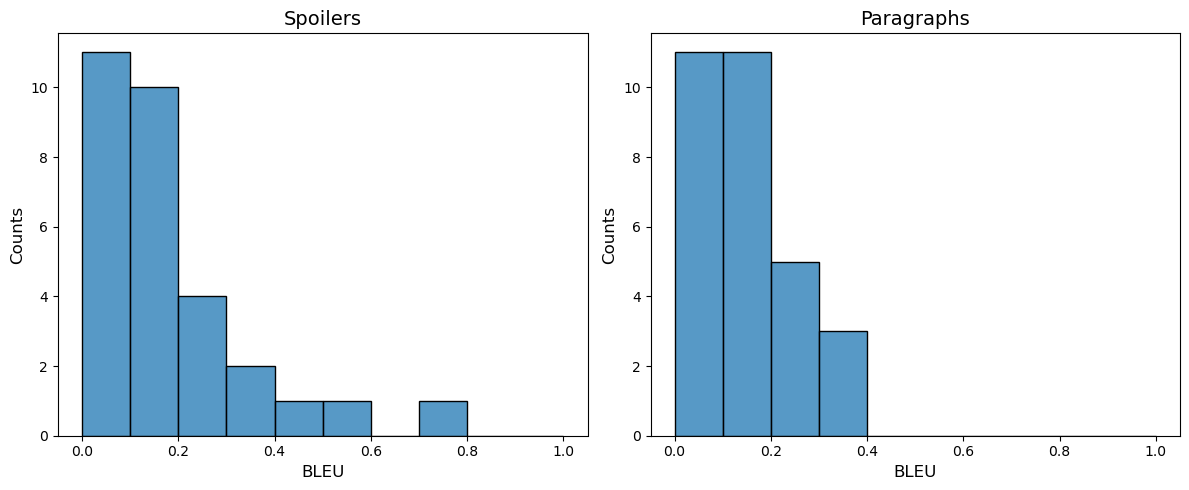

In [119]:
xlabels = ['BLEU','BLEU']
titles = ['Spoilers','Paragraphs']
plotHistograms(metrics_df, columns=["humanSpoiler_bleu", "spoiler_bleu"], xlabels=xlabels, titles=titles, kde=False, log=False, font_size=12)

In [120]:
print("Mean of humanSpoiler_bleu: ", metrics_df["humanSpoiler_bleu"].mean())
print("Mean of spoiler_bleu: ", metrics_df["spoiler_bleu"].mean())

Mean of humanSpoiler_bleu:  0.16623333333333337
Mean of spoiler_bleu:  0.12986666666666669


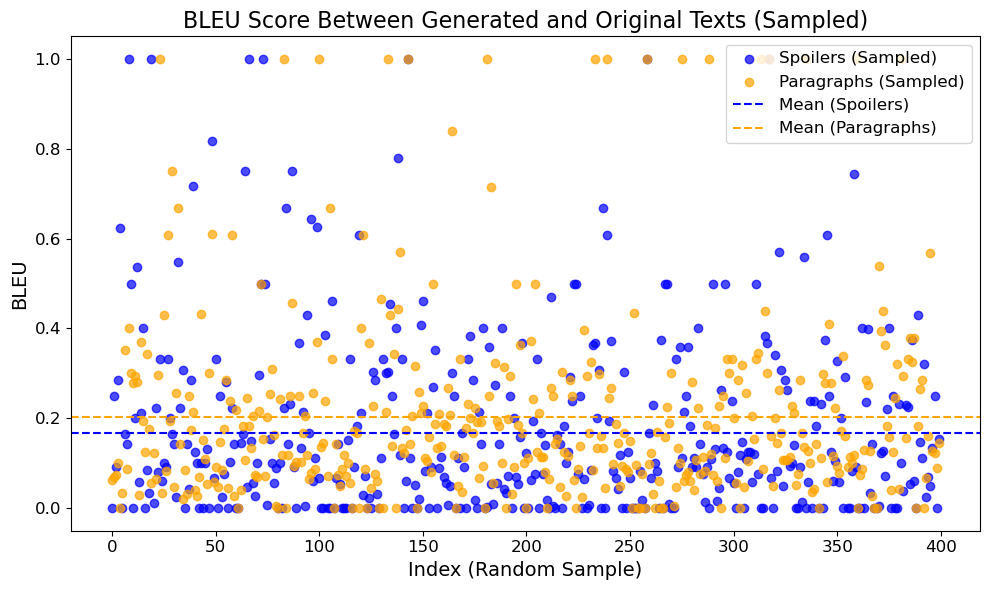

In [75]:
plot_scatterplot(
    df=metrics_df, 
    columns=["humanSpoiler_bleu", "spoiler_bleu"], 
    legend_labels=['Spoilers (Sampled)', 'Paragraphs (Sampled)'], 
    mean_labels=['Mean (Spoilers)', 'Mean (Paragraphs)'], 
    xlabel='Index (Random Sample)', 
    ylabel='BLEU', 
    title='BLEU Score Between Generated and Original Texts (Sampled)', 
    random_state=RANDOM_STATE, 
    n=N)

#### BERTScore (BSc) for spoiler, humanSpoiler
https://haticeozbolat17.medium.com/text-summarization-how-to-calculate-bertscore-771a51022964 <br>
https://rumn.medium.com/bert-score-explained-8f384d37bb06

In [121]:
scorer = BERTScorer(model_type='bert-base-uncased', lang="en")

def calculate_bertscore(row, columns):
    P, R, F1 = scorer.score([row[columns[0]]], [row[columns[1]]])
    return P.mean().item(), R.mean().item(), F1.mean().item()

In [122]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

def calculate_bert_similarity(row, columns):
    embeddings = []
    for column in columns:
        text = row[column]
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        outputs = model(**inputs)
        # The mean of the last hidden state. Squeeze to remove batch dimension.
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
        embeddings.append(embedding)
    
    similarity = np.dot(embeddings[0], embeddings[1]) / (np.linalg.norm(embeddings[0]) * np.linalg.norm(embeddings[1]))
    return similarity

metrics_df["bertScore"] = metrics_df.apply(calculate_bert_similarity, columns=["humanSpoiler_org", "humanSpoiler_ext"], axis=1)


In [123]:
# this cell executes for longer time ~ 9 minutes
metrics_df[["hs_bert_precision", "hs_bert_recall", "hs_bert_f1"]] = metrics_df[["humanSpoiler_org", "humanSpoiler_ext"]].apply(calculate_bertscore, columns=["humanSpoiler_org", "humanSpoiler_ext"], axis=1, result_type="expand")
metrics_df[["s_bert_precision", "s_bert_recall", "s_bert_f1"]] = metrics_df[["spoiler_org", "spoiler_ext"]].apply(calculate_bertscore, columns=["spoiler_org", "spoiler_ext"], axis=1, result_type="expand")

In [124]:
# this chart might be better
metrics_df["index"] = metrics_df.index
metrics_long = metrics_df.melt(
    id_vars="index", 
    value_vars=["hs_bert_precision", "s_bert_precision"], 
    var_name="Line Type", 
    value_name="Precision"
)
fig = px.line(
    metrics_long, 
    x="index", 
    y="Precision", 
    color="Line Type", 
    title="BERT Precision Comparison", 
    labels={"index": "Index", "Precision": "Precision"}
)

fig.update_layout(
    title_font_size=20,
    xaxis_title_font_size=16,
    yaxis_title_font_size=16,
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    template="plotly_white"
)

fig.show()

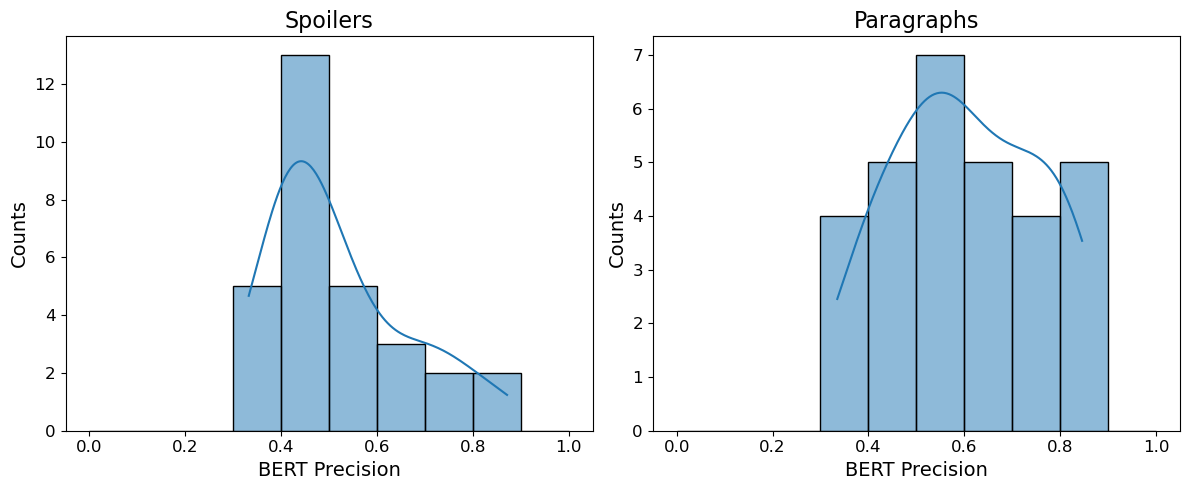

In [125]:
xlabels = ['BERT Precision','BERT Precision']
titles = ['Spoilers','Paragraphs']
plotHistograms(metrics_df, columns=["hs_bert_precision", "s_bert_precision"], xlabels=xlabels, titles=titles, kde=True, font_size=14)

In [126]:
# this cell executes long time ~ 14 minutes
metrics_df["humanSpoiler_bertScore"] = metrics_df.apply(calculate_bert_similarity, columns=["humanSpoiler_org", "humanSpoiler_ext"], axis=1)
metrics_df["spoiler_bertScore"] = metrics_df.apply(calculate_bert_similarity, columns=["spoiler_org", "spoiler_ext"], axis=1)

In [127]:
print("Mean of humanSpoiler_bertScore: ", metrics_df["humanSpoiler_bertScore"].mean())
print("Mean of spoiler_bertScore: ", metrics_df["spoiler_bertScore"].mean())

Mean of humanSpoiler_bertScore:  0.64588183
Mean of spoiler_bertScore:  0.6435379


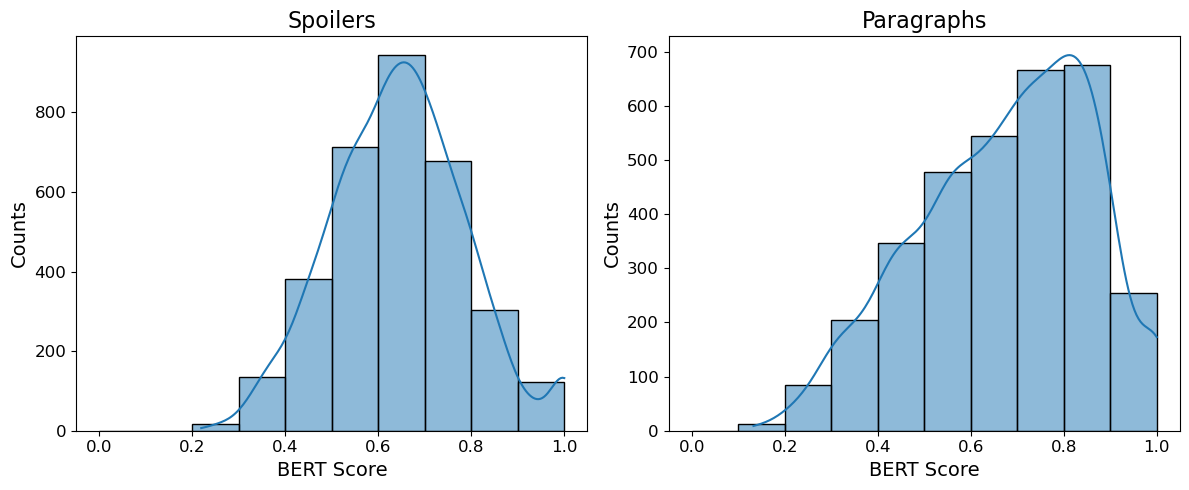

In [37]:
xlabels = ['BERT Score','BERT Score']
titles = ['Spoilers','Paragraphs']
plotHistograms(metrics_df, columns=["humanSpoiler_bertScore", "spoiler_bertScore"], xlabels=xlabels, titles=titles, kde=True, font_size=14)

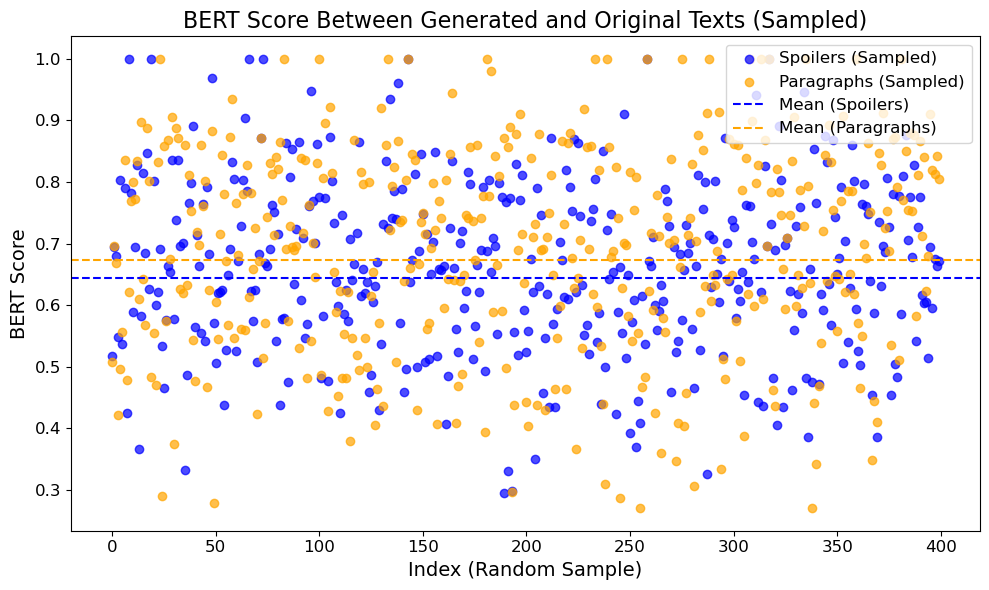

In [113]:
plot_scatterplot(
    df=metrics_df, 
    columns=["humanSpoiler_bertScore", "spoiler_bertScore"], 
    legend_labels=['Spoilers (Sampled)', 'Paragraphs (Sampled)'], 
    mean_labels=['Mean (Spoilers)', 'Mean (Paragraphs)'], 
    xlabel='Index (Random Sample)', 
    ylabel='BERT Score', 
    title='BERT Score Between Generated and Original Texts (Sampled)', 
    random_state=RANDOM_STATE, 
    n=N)

### Saving dataset with spoilers and calculated metrics on them

In [75]:
metrics_df.to_csv("../data/spoiling_metrics_df.csv", index=False, sep=";", header=True)